<center> <h1> Detecting COVID-19 with Chest X Ray using PyTorch </h1></center>

The task is to classify chest X-Ray scan images into 3 classes: 
1. Normal
2. Viral Pneumonia
3. COVID-19

The dataset used here is the **COVID-19 Radiography Dataset** obtained from [Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database).

---

### Importing Libraries

Let us import the required libraries...

In [6]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.9.0+cu102


### Preparing Training and Test Sets

In [7]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

### Creating Custom Dataset

In [8]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal','viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        
        # Ensures that index is not out of bounds
        # Since classes have different number of images (class imbalance problem)
        index = index % len(self.images[class_name])
        index_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], index_name)
        image = Image.open(image_path).convert('RGB')
        
        # Return the transformed image and its class label
        return self.transform(image), self.class_names.index(class_name)
        
        

### Image Transformations

Let us create 2 transform objects -- one each for train and test set.

In [9]:
train_transform = torchvision.transforms.Compose([
    
    # ResNet-18 Model will be used which has weights pretrained on 'imagenet' dataset
    # This requires images to be resized.
    torchvision.transforms.Resize(size=(224,224)),
    
    # Data augmentation - Horizontal Flip
    torchvision.transforms.RandomHorizontalFlip(),
    
    # Convert image to tensor
    torchvision.transforms.ToTensor(),
    
    # Normalising the values
    # To take advantage of transfer learning, 
    # normalise in the same way that 'imagenet' was normalised
    # So specify the mean and standard deviation for 3 channels (RGB)
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])


Now, let us create the test transform object. The only difference is that data augmenation (Horizontal Flip) is not required for test data.

In [10]:
test_transform = torchvision.transforms.Compose([
    
    # ResNet-18 Model will be used which has weights pretrained on 'imagenet' dataset
    # This requires images to be resized.
    torchvision.transforms.Resize(size=(224,224)),
    
    # Convert image to tensor
    torchvision.transforms.ToTensor(),
    
    # Normalising the values
    # To take advantage of transfer learning, 
    # normalise in the same way that 'imagenet' was normalised
    # So specify the mean and standard deviation for 3 channels (RGB)
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])


### Prepare DataLoader

In [11]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [12]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [13]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of train batches =', len(dl_train))
print('Number of test batches =', len(dl_test))

Number of train batches = 470
Number of test batches = 15


### Data Visualisation

In [14]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i+1, xticks=[], yticks=[])
        
        # Convert to from tensor to numpy
        # Take its transpose because
        # In ResNet implementation, the format for input is n_channels * n_height * n_width (!and not n_height * n_width * n_channels)
        image = image.numpy().transpose((1, 2, 0))  # Set axes
        
        # Images were normalised earlier.
        # To show the image denormalise the images
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        image = image*std + mean
        image = np.clip(image, 0.,1.)
        plt.imshow(image)
        
        colour = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=colour)
        
    plt.tight_layout()
    plt.show()
        

**Issue**: Kernel dies on running the following 2 code cells.

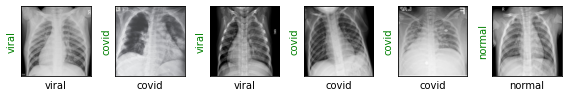

In [15]:
images, labels = next(iter(dl_train))

# Since predictions are not available for training data yet
# Labels are used in place of predictions
show_images(images, labels, labels)

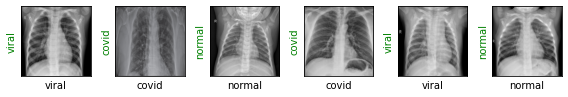

In [16]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

### Creating the Model

In [17]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Modify the last (fully connected) layer by setting the number of `out_features` to 3 since we have 3 classes.

In [18]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [19]:
def show_preds():
    resnet18.eval()    # set to evaluation mode
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _ , preds = torch.max(outputs, 1)
    show_images(images, labels, preds)
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


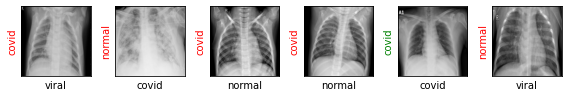

In [20]:
show_preds()

### Training the Model

In [21]:
def train(epochs):
    print('Started training...')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet18.train()   # set to training mode
        
        for train_step, (images, labels) in enumerate(dl_train):
            
            # Refresh optimizer and set gradients to zero
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print('Evaluating at step:', train_step)
                acc = 0.
                val_loss = 0.
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _ , preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                    
                val_loss /= (val_step + 1)
                acc /= len(test_dataset)
                print(f'Val loss = {val_loss:.4f}, Accuracy = {acc:.4f}')
                show_preds()
                
                resnet18.train()
                
                if acc > 0.95:
                    print('Performance condition satisifed, hence stopping...')
                    return
                
        train_loss /= (train_step+1)
        print(f'Training loss = {train_loss:.4f}')
     

Started training...
Starting epoch 1/1
Evaluating at step: 0
Val loss = 1.2060, Accuracy = 0.3111


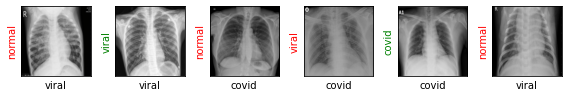

Evaluating at step: 20
Val loss = 0.4962, Accuracy = 0.8667


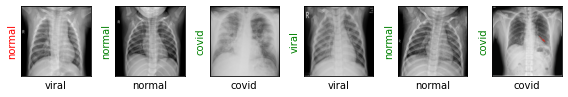

Evaluating at step: 40
Val loss = 0.3586, Accuracy = 0.8778


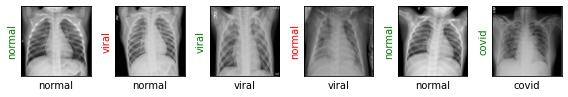

Evaluating at step: 60
Val loss = 0.1805, Accuracy = 0.9444


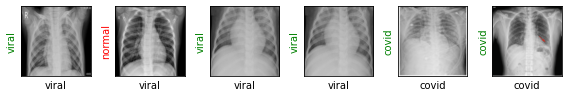

Evaluating at step: 80
Val loss = 0.1578, Accuracy = 0.9333


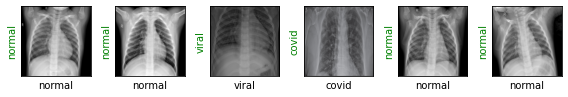

Evaluating at step: 100
Val loss = 0.2804, Accuracy = 0.8778


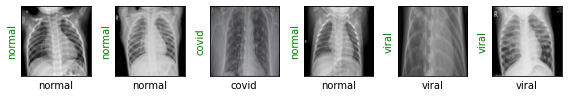

Evaluating at step: 120
Val loss = 0.2508, Accuracy = 0.9222


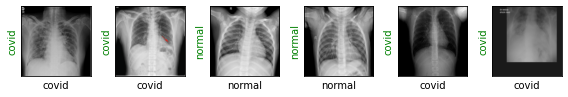

Evaluating at step: 140
Val loss = 0.1517, Accuracy = 0.9667


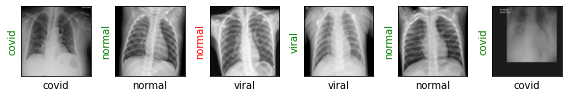

Performance condition satisifed, hence stopping...


In [22]:
train(epochs=1)

### Final Results

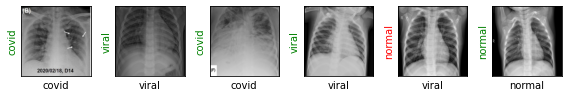

In [23]:
show_preds()